# NLU Intent Classification & Slot Filling

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
device = 'cuda:0' # cuda:0 means we are using the GPU with id 0, if you have multiple GPU
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" # Used to report errors on CUDA side
PAD_TOKEN = 0

In [ ]:
import json
from pprint import pprint
import random
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.optim as optim

# Data Utils

In [ ]:
def load_data(path):
    '''
        input: path/to/data
        output: json 
    '''
    dataset = []
    with open(path) as f:
        dataset = json.loads(f.read())
    return dataset

In [ ]:
from collections import Counter

class Lang():
    def __init__(self, words, intents, slots, cutoff=0):
        self.word2id = self.w2id(words, cutoff=cutoff, unk=True)
        self.slot2id = self.lab2id(slots)
        self.intent2id = self.lab2id(intents, pad=False)
        self.id2word = {v:k for k, v in self.word2id.items()}
        self.id2slot = {v:k for k, v in self.slot2id.items()}
        self.id2intent = {v:k for k, v in self.intent2id.items()}
        
    def w2id(self, elements, cutoff=None, unk=True):
        vocab = {'pad': PAD_TOKEN}
        if unk:
            vocab['unk'] = len(vocab)
        count = Counter(elements)
        for k, v in count.items():
            if v > cutoff:
                vocab[k] = len(vocab)
        return vocab
    
    def lab2id(self, elements, pad=True):
        vocab = {}
        if pad:
            vocab['pad'] = PAD_TOKEN
        for elem in elements:
                vocab[elem] = len(vocab)
        return vocab

In [ ]:
import torch
import torch.utils.data as data

class IntentsAndSlots (data.Dataset):
    # Mandatory methods are __init__, __len__ and __getitem__
    def __init__(self, dataset, lang, unk='unk'):
        self.utterances = []
        self.intents = []
        self.slots = []
        self.unk = unk
        
        for x in dataset:
            self.utterances.append(x['utterance'])
            self.slots.append(x['slots'])
            self.intents.append(x['intent'])

        self.utt_ids = self.mapping_seq(self.utterances, lang.word2id)
        self.slot_ids = self.mapping_seq(self.slots, lang.slot2id)
        self.intent_ids = self.mapping_lab(self.intents, lang.intent2id)

    def __len__(self):
        return len(self.utterances)

    def __getitem__(self, idx):
        utt = torch.Tensor(self.utt_ids[idx])
        slots = torch.Tensor(self.slot_ids[idx])
        intent = self.intent_ids[idx]
        sample = {'utterance': utt, 'slots': slots, 'intent': intent}
        return sample
    
    # Auxiliary methods
    def mapping_lab(self, data, mapper):
        return [mapper[x] if x in mapper else mapper[self.unk] for x in data]
    
    def mapping_seq(self, data, mapper): # Map sequences to number
        res = []
        for seq in data:
            tmp_seq = []
            for x in seq.split():
                if x in mapper:
                    tmp_seq.append(mapper[x])
                else:
                    tmp_seq.append(mapper[self.unk])
            res.append(tmp_seq)
        return res


In [ ]:
from torch.utils.data import DataLoader

def collate_fn(data):
    def merge(sequences):
        '''
        merge from batch * sent_len to batch * max_len 
        '''
        lengths = [len(seq) for seq in sequences]
        max_len = 1 if max(lengths)==0 else max(lengths)
        # Pad token is zero in our case
        # So we create a matrix full of PAD_TOKEN (i.e. 0) with the shape 
        # batch_size X maximum length of a sequence
        padded_seqs = torch.LongTensor(len(sequences),max_len).fill_(PAD_TOKEN)
        for i, seq in enumerate(sequences):
            end = lengths[i]
            padded_seqs[i, :end] = seq # We copy each sequence into the matrix
        # print(padded_seqs)
        padded_seqs = padded_seqs.detach()  # We remove these tensors from the computational graph
        return padded_seqs, lengths
    # Sort data by seq lengths
    data.sort(key=lambda x: len(x['utterance']), reverse=True) 
    new_item = {}
    for key in data[0].keys():
        new_item[key] = [d[key] for d in data]
    # We just need one length for packed pad seq, since len(utt) == len(slots)
    src_utt, _ = merge(new_item['utterance'])
    y_slots, y_lengths = merge(new_item["slots"])
    intent = torch.LongTensor(new_item["intent"])
    
    src_utt = src_utt#.to(device) # We load the Tensor on our seleceted device
    y_slots = y_slots#.to(device)
    intent = intent#.to(device)
    y_lengths = torch.LongTensor(y_lengths)#.to(device)
    
    new_item["utterances"] = src_utt
    new_item["intents"] = intent
    new_item["y_slots"] = y_slots
    new_item["slots_len"] = y_lengths
    return new_item


In [ ]:
def get_lang(train_raw, dev_raw, test_raw):
    words = sum([x['utterance'].split() for x in train_raw], []) # No set() since we want to compute the cutoff
    corpus = train_raw + dev_raw + test_raw # We do not wat unk labels, 
                                            # however this depends on the research purpose
    slots = set(sum([line['slots'].split() for line in corpus],[]))
    intents = set([line['intent'] for line in corpus])

    return Lang(words, intents, slots, cutoff=0)

# Data Loading

Load raw data from json files, both for test and train set.

The SNIPS dataset also contains a dedicated file for validation set, while this has to be obtained for ATIS, from a subset of the train set.

In [ ]:
tmp_train_raw_ATIS = load_data(os.path.join('./drive/MyDrive/data/','atis','train.json'))
test_raw_ATIS = load_data(os.path.join('./drive/MyDrive/data/','atis','test.json'))

In [ ]:
train_raw_SNIPS   = load_data(os.path.join('./drive/MyDrive/data/','snips','train.json'))
test_raw_SNIPS = load_data(os.path.join('./drive/MyDrive/data/','snips','test.json'))
dev_raw_SNIPS = load_data(os.path.join('./drive/MyDrive/data/','snips','valid.json'))

In [ ]:
# Firt we get the 10% of dataset, then we compute the percentage of these examples 
# on the training set which is around 11% 
portion = round(((len(tmp_train_raw_ATIS) + len(test_raw_ATIS)) * 0.10)/(len(tmp_train_raw_ATIS)),2)


intents_ATIS = [x['intent'] for x in tmp_train_raw_ATIS] # We stratify on intents
count_y_ATIS = Counter(intents_ATIS)

Y_ATIS = []
X_ATIS = []
mini_Train_ATIS = []

for id_y, y in enumerate(intents_ATIS):
    # IT MAKES NO SENSE TO PUT IN DEV SET INTENTS THAT ONLY APPEAR ONCE
    if count_y_ATIS[y] > 1: # Some intents have only one instance, we put them in training
        X_ATIS.append(tmp_train_raw_ATIS[id_y])
        Y_ATIS.append(y)
    else:
        mini_Train_ATIS.append(tmp_train_raw_ATIS[id_y])
# Random Stratify
X_train_ATIS, X_dev_ATIS, y_train_ATIS, y_dev_ATIS = train_test_split(X_ATIS, Y_ATIS, test_size=portion, 
                                                    random_state=42, 
                                                    shuffle=True,
                                                    stratify=Y_ATIS)
X_train_ATIS.extend(mini_Train_ATIS)
train_raw_ATIS = X_train_ATIS
dev_raw_ATIS = X_dev_ATIS

y_test_ATIS = [x['intent'] for x in test_raw_ATIS]

In [ ]:
lang_ATIS = get_lang(train_raw_ATIS, dev_raw_ATIS, test_raw_ATIS)
lang_SNIPS = get_lang(train_raw_SNIPS, dev_raw_SNIPS, test_raw_SNIPS)

In [ ]:
train_dataset_ATIS = IntentsAndSlots(train_raw_ATIS, lang_ATIS)
dev_dataset_ATIS = IntentsAndSlots(dev_raw_ATIS, lang_ATIS)
test_dataset_ATIS = IntentsAndSlots(test_raw_ATIS, lang_ATIS)

In [ ]:
train_dataset_SNIPS = IntentsAndSlots(train_raw_SNIPS, lang_SNIPS)
dev_dataset_SNIPS = IntentsAndSlots(dev_raw_SNIPS, lang_SNIPS)
test_dataset_SNIPS = IntentsAndSlots(test_raw_SNIPS, lang_SNIPS)

In [ ]:
# Dataloader instantiation
train_loader_ATIS = DataLoader(train_dataset_ATIS, batch_size=128, collate_fn=collate_fn,  shuffle=True)
dev_loader_ATIS = DataLoader(dev_dataset_ATIS, batch_size=64, collate_fn=collate_fn)
test_loader_ATIS = DataLoader(test_dataset_ATIS, batch_size=64, collate_fn=collate_fn)

In [ ]:
# Dataloader instantiation
train_loader_SNIPS = DataLoader(train_dataset_SNIPS, batch_size=128, collate_fn=collate_fn,  shuffle=True)
dev_loader_SNIPS = DataLoader(dev_dataset_SNIPS, batch_size=64, collate_fn=collate_fn)
test_loader_SNIPS = DataLoader(test_dataset_SNIPS, batch_size=64, collate_fn=collate_fn)

In [ ]:
out_slot_ATIS = len(lang_ATIS.slot2id)
out_int_ATIS = len(lang_ATIS.intent2id)
vocab_len_ATIS = len(lang_ATIS.word2id)

out_slot_SNIPS = len(lang_SNIPS.slot2id)
out_int_SNIPS = len(lang_SNIPS.intent2id)
vocab_len_SNIPS = len(lang_SNIPS.word2id)

# Datasets Stats

To describe each dataset in the report, the number of samples is computed, as well as the first item of the train set is printed 

In [ ]:
def get_dataset_stats(train, test, valid=None):
    print('Train samples:', len(train))
    if valid is not None: 
      print('Validation samples:', len(valid))
    print('Test samples:', len(test))
    pprint(train[0])

In [ ]:
get_dataset_stats(train_raw_ATIS, test_raw_ATIS, dev_raw_ATIS)

Train samples: 4381
Validation samples: 597
Test samples: 893
{'intent': 'aircraft',
 'slots': 'O O O O O B-airline_name O O B-fromloc.city_name O '
          'B-toloc.city_name B-depart_time.time_relative B-depart_time.time '
          'I-depart_time.time',
 'utterance': 'what type of aircraft does eastern fly from atlanta to denver '
              'before 6 pm'}


In [ ]:
get_dataset_stats(train_raw_SNIPS, test_raw_SNIPS, dev_raw_SNIPS)

Train samples: 13084
Validation samples: 700
Test samples: 700
{'intent': 'PlayMusic',
 'slots': 'O O B-artist O B-album O B-service I-service',
 'utterance': 'listen to westbam alumb allergic on google music'}


# Conll.py

In [ ]:
import re

"""
Modified version of https://pypi.org/project/conlleval/
"""


def stats():
    return {'cor': 0, 'hyp': 0, 'ref': 0}


def evaluate(ref, hyp, otag='O'):
    # evaluation for NLTK
	#print(len(ref), len(hyp))
	aligned = align_hyp(ref, hyp)
	return conlleval(aligned, otag=otag)


def align_hyp(ref, hyp):
    # align references and hypotheses for evaluation
    # add last element of token tuple in hyp to ref
    if len(ref) != len(hyp):
        raise ValueError("Size Mismatch: ref: {} & hyp: {}".format(len(ref), len(hyp)))

    out = []
    for i in range(len(ref)):
        if len(ref[i]) != len(hyp[i]):
            raise ValueError("Size Mismatch: ref: {} & hyp: {}".format(len(ref), len(hyp)))
        out.append([(*ref[i][j], hyp[i][j][-1]) for j in range(len(ref[i]))])
    return out


def conlleval(data, otag='O'):
    # token, segment & class level counts for TP, TP+FP, TP+FN
    tok = stats()
    seg = stats()
    cls = {}

    for sent in data:

        prev_ref = otag      # previous reference label
        prev_hyp = otag      # previous hypothesis label
        prev_ref_iob = None  # previous reference label IOB
        prev_hyp_iob = None  # previous hypothesis label IOB

        in_correct = False  # currently processed chunks is correct until now

        for token in sent:

            hyp_iob, hyp = parse_iob(token[-1])
            ref_iob, ref = parse_iob(token[-2])

            ref_e = is_eoc(ref, ref_iob, prev_ref, prev_ref_iob, otag)
            hyp_e = is_eoc(hyp, hyp_iob, prev_hyp, prev_hyp_iob, otag)

            ref_b = is_boc(ref, ref_iob, prev_ref, prev_ref_iob, otag)
            hyp_b = is_boc(hyp, hyp_iob, prev_hyp, prev_hyp_iob, otag)

            if not cls.get(ref) and ref:
                cls[ref] = stats()

            if not cls.get(hyp) and hyp:
                cls[hyp] = stats()

            # segment-level counts
            if in_correct:
                if ref_e and hyp_e and prev_hyp == prev_ref:
                    in_correct = False
                    seg['cor'] += 1
                    cls[prev_ref]['cor'] += 1

                elif ref_e != hyp_e or hyp != ref:
                    in_correct = False

            if ref_b and hyp_b and hyp == ref:
                in_correct = True

            if ref_b:
                seg['ref'] += 1
                cls[ref]['ref'] += 1

            if hyp_b:
                seg['hyp'] += 1
                cls[hyp]['hyp'] += 1

            # token-level counts
            if ref == hyp and ref_iob == hyp_iob:
                tok['cor'] += 1

            tok['ref'] += 1

            prev_ref = ref
            prev_hyp = hyp
            prev_ref_iob = ref_iob
            prev_hyp_iob = hyp_iob

        if in_correct:
            seg['cor'] += 1
            cls[prev_ref]['cor'] += 1

    return summarize(seg, cls)


def parse_iob(t):
    m = re.match(r'^([^-]*)-(.*)$', t)
    return m.groups() if m else (t, None)


def is_boc(lbl, iob, prev_lbl, prev_iob, otag='O'):
    """
    is beginning of a chunk
    supports: IOB, IOBE, BILOU schemes
        - {E,L} --> last
        - {S,U} --> unit
    :param lbl: current label
    :param iob: current iob
    :param prev_lbl: previous label
    :param prev_iob: previous iob
    :param otag: out-of-chunk label
    :return:
    """
    boc = False

    boc = True if iob in ['B', 'S', 'U'] else boc
    boc = True if iob in ['E', 'L'] and prev_iob in ['E', 'L', 'S', otag] else boc
    boc = True if iob == 'I' and prev_iob in ['S', 'L', 'E', otag] else boc

    boc = True if lbl != prev_lbl and iob != otag and iob != '.' else boc

    # these chunks are assumed to have length 1
    boc = True if iob in ['[', ']'] else boc

    return boc


def is_eoc(lbl, iob, prev_lbl, prev_iob, otag='O'):
    """
    is end of a chunk
    supports: IOB, IOBE, BILOU schemes
        - {E,L} --> last
        - {S,U} --> unit
    :param lbl: current label
    :param iob: current iob
    :param prev_lbl: previous label
    :param prev_iob: previous iob
    :param otag: out-of-chunk label
    :return:
    """
    eoc = False

    eoc = True if iob in ['E', 'L', 'S', 'U'] else eoc
    eoc = True if iob == 'B' and prev_iob in ['B', 'I'] else eoc
    eoc = True if iob in ['S', 'U'] and prev_iob in ['B', 'I'] else eoc

    eoc = True if iob == otag and prev_iob in ['B', 'I'] else eoc

    eoc = True if lbl != prev_lbl and iob != otag and prev_iob != '.' else eoc

    # these chunks are assumed to have length 1
    eoc = True if iob in ['[', ']'] else eoc

    return eoc


def score(cor_cnt, hyp_cnt, ref_cnt):
    # precision
    p = 1 if hyp_cnt == 0 else cor_cnt / hyp_cnt
    # recall
    r = 0 if ref_cnt == 0 else cor_cnt / ref_cnt
    # f-measure (f1)
    f = 0 if p+r == 0 else (2*p*r)/(p+r)
    return {"p": p, "r": r, "f": f, "s": ref_cnt}


def summarize(seg, cls):
    # class-level
    res = {lbl: score(cls[lbl]['cor'], cls[lbl]['hyp'], cls[lbl]['ref']) for lbl in set(cls.keys())}
    # micro
    res.update({"total": score(seg.get('cor', 0), seg.get('hyp', 0), seg.get('ref', 0))})
    return res


def read_corpus_conll(corpus_file, fs="\t"):
    """
    read corpus in CoNLL format
    :param corpus_file: corpus in conll format
    :param fs: field separator
    :return: corpus
    """
    featn = None  # number of features for consistency check
    sents = []  # list to hold words list sequences
    words = []  # list to hold feature tuples

    for line in open(corpus_file):
        line = line.strip()
        if len(line.strip()) > 0:
            feats = tuple(line.strip().split(fs))
            if not featn:
                featn = len(feats)
            elif featn != len(feats) and len(feats) != 0:
                raise ValueError("Unexpected number of columns {} ({})".format(len(feats), featn))

            words.append(feats)
        else:
            if len(words) > 0:
                sents.append(words)
                words = []
    return sents


def get_chunks(corpus_file, fs="\t", otag="O"):
    sents = read_corpus_conll(corpus_file, fs=fs)
    return set([parse_iob(token[-1])[1] for sent in sents for token in sent if token[-1] != otag])

# Plotting Losses and Confusion Matrix

To plot the training and validation loss, as well as the confusion matrices for the test phase, the two following auxiliary functions are used.

In [ ]:
def plot_losses(epochs, losses_train, losses_dev):
    plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
    plt.title('Train and Dev Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(epochs, losses_train, label='Train Loss')
    plt.plot(epochs, losses_dev, label='Dev Loss')
    plt.legend()
    plt.show()

In [ ]:
import matplotlib

def plot_confusion_matrix(data, label="Confusion Matrix"):
    plt.figure(figsize = (10,10))
    plt.title(label)
    plt.imshow(data, norm = matplotlib.colors.Normalize(vmin = 0, vmax = 255))

# Early Stopping

In [ ]:
class EarlyStopping(): 
    def __init__(self, max_patience): 
        self.max_patience = max_patience 
        self.patience = max_patience
        self.best = 0

    def reset(self): 
        self.patience = self.max_patience
        self.best = 0

    def update(self, value): 
        if value > self.best:
            self.best = value
        else:
            self.patience -= 1
        
        if self.patience <= 0:
            return False 

        return True

# Train and Test Loops

Simple train and test loop taken from the baseline code for the assigment 

In [ ]:
def train_loop(data, optimizer, criterion_slots, criterion_intents, model):
    model.train()
    loss_array = []
    for i,sample in enumerate(data):
        optimizer.zero_grad() # Zeroing the gradient
        slots, intent = model(sample['utterances'], sample['slots_len'])
        loss_intent = criterion_intents(intent, sample['intents'])
        loss_slot = criterion_slots(slots, sample['y_slots'])
        loss = loss_intent+loss_slot # In joint training we sum the losses. 
        loss_array.append(loss.item())
        loss.backward() # Compute the gradient, deleting the computational graph
        optimizer.step() # Update the weights
    return loss_array

In [ ]:
def eval_loop(data, criterion_slots, criterion_intents, model, lang):
    model.eval()
    loss_array = []
    
    ref_intents = []
    hyp_intents = []
    
    ref_slots = []
    hyp_slots = []
    #softmax = nn.Softmax(dim=1) # Use Softmax if you need the actual probability
    with torch.no_grad(): # It used to avoid the creation of computational graph
        total_slot_labels = [x for x in range (len(lang.id2slot))]
        total_intent_labels = [v for k, v in lang.id2intent.items()]
        cm_slot = np.zeros((len(total_slot_labels), len(total_slot_labels)))
        cm_intent = np.zeros((len(total_intent_labels), len(total_intent_labels)))
        for sample in data:
            slots, intents = model(sample['utterances'], sample['slots_len'])
            loss_intent = criterion_intents(intents, sample['intents'])
            loss_slot = criterion_slots(slots, sample['y_slots'])
            loss = loss_intent + loss_slot 
            loss_array.append(loss.item())
            # Intent inference
            # Get the highest probable class
            out_intents = [lang.id2intent[x] 
                           for x in torch.argmax(intents, dim=1).tolist()] 
            gt_intents = [lang.id2intent[x] for x in sample['intents'].tolist()]
            ref_intents.extend(gt_intents)
            hyp_intents.extend(out_intents)
            # Slot inference 
            output_slots = torch.argmax(slots, dim=1)

            ref_int_labels = []
            hyp_int_labels = []

            for id_seq, seq in enumerate(output_slots):
                length = sample['slots_len'].tolist()[id_seq]
                utt_ids = sample['utterance'][id_seq][:length].tolist()
                gt_ids = sample['y_slots'][id_seq].tolist()
                gt_slots = [lang.id2slot[elem] for elem in gt_ids[:length]]
                utterance = [lang.id2word[elem] for elem in utt_ids]
                to_decode = seq[:length].tolist()
                ref_slots.append([(utterance[id_el], elem) for id_el, elem in enumerate(gt_slots)])
                tmp_seq = []
                for id_el, elem in enumerate(to_decode):
                  tmp_seq.append((utterance[id_el], lang.id2slot[elem]))
                  ref_int_labels.extend(gt_ids[:length])
                  hyp_int_labels.extend(to_decode)
                    
                hyp_slots.append(tmp_seq)

        X = [lang.id2slot[x] for x in ref_int_labels]
        Y = [lang.id2slot[x] for x in hyp_int_labels]
        labels = [lang.id2slot[x] for x in total_slot_labels]

        cm_slot += confusion_matrix(X, Y,labels = labels)
        cm_intent += confusion_matrix(ref_intents, hyp_intents,labels = total_intent_labels)
    
    try:            
        results = evaluate(ref_slots, hyp_slots)
    except Exception as ex:
        # Sometimes the model predics a class that is not in REF
        results = None
    
    #results = sklearn.metrics.f1_score([lang.id2slot[x] for x in ref_int_labels], [lang.id2slot[x] for x in hyp_int_labels], average = 'weighted')
    
    report_intent = classification_report(ref_intents, hyp_intents, 
                                          zero_division=False, output_dict=True)
    return results, report_intent, loss_array

# Eval loop with confusion matrices

Modified evaluation loop to also keep track of confusion matrix information, in four lists:

```
	ref_intents = intent ground truth
	hyp_intents = intent hypothesis from model
	ref_slots = slots ground truth
	hyp_slots = slots hypothesis from model

```

In [ ]:

from sklearn.metrics import classification_report, confusion_matrix

def eval_loop_wcm(data, criterion_slots, criterion_intents, model, lang):
	model.eval()
	loss_array = []
	
	ref_intents = []
	hyp_intents = []
	
	ref_slots = []
	hyp_slots = []

	slot_label_ids = [sl for sl in range (len(lang.id2slot))]
	intent_labels = [v for k, v in lang.id2intent.items()]
	conf_mat_slots = np.zeros((len(slot_label_ids), len(slot_label_ids)))
	conf_mat_intents = np.zeros((len(intent_labels), len(intent_labels)))
	
	with torch.no_grad(): # It used to avoid the creation of computational graph
		for sample in data:
			slots, intents = model(sample['utterances'], sample['slots_len'])

			loss_intent = criterion_intents(intents, sample['intents'])
			loss_slot = criterion_slots(slots, sample['y_slots'])
			loss = loss_intent + loss_slot 
			loss_array.append(loss.item())
			# Intent inference
			# Get the highest probable class
			out_intents = [lang.id2intent[x] for x in torch.argmax(intents, dim=1).tolist()] 
			gt_intents = [lang.id2intent[x] for x in sample['intents'].tolist()]
			ref_intents.extend(gt_intents)
			hyp_intents.extend(out_intents)
	 
			ref_intent_labels = []
			hyp_intent_labels = []
			
			# Slot inference 
			output_slots = torch.argmax(slots, dim=1)
			for id_seq, seq in enumerate(output_slots):
				length = sample['slots_len'].tolist()[id_seq]
				utt_ids = sample['utterance'][id_seq][:length].tolist()
				gt_ids = sample['y_slots'][id_seq].tolist()
				gt_slots = [lang.id2slot[elem] for elem in gt_ids[:length]]
				utterance = [lang.id2word[elem] for elem in utt_ids]
				to_decode = seq[:length].tolist()
				ref_slots.append([(utterance[id_el], elem) for id_el, elem in enumerate(gt_slots)])
				tmp_seq = []
				
				for id_el, elem in enumerate(to_decode):
					tmp_seq.append((utterance[id_el], lang.id2slot[elem]))
					ref_intent_labels.extend(gt_ids[:length])
					hyp_intent_labels.extend(to_decode)
	
				hyp_slots.append(tmp_seq)

			X = [lang.id2slot[x] for x in ref_intent_labels]
			Y = [lang.id2slot[x] for x in hyp_intent_labels]
			slot_labels = [lang.id2slot[x] for x in slot_label_ids]

			conf_mat_slots += confusion_matrix(X, Y,labels = slot_labels)
			conf_mat_intents += confusion_matrix(ref_intents, hyp_intents,labels = intent_labels)

	try:         
		results = evaluate(ref_slots, hyp_slots)
	except Exception as ex:
  	# Sometimes the model predics a class that is not in REF
		print(ex)
		ref_s = set([x[1] for x in ref_slots])
		hyp_s = set([x[1] for x in hyp_slots])
		
		print(hyp_s.difference(ref_s))
		results = []
		
	report_intent = classification_report(ref_intents, hyp_intents, zero_division=False, output_dict=True)
	return results, report_intent, loss_array, conf_mat_slots, conf_mat_intents


# Train and eval function for 5 iterations

Auxiliary function to train the same model five times depending on the type passed. 

Also prints intermediate results, and not just mean and variance, in case colab stops the execution.

In [ ]:
def train_5_times(model_type, train_loader, dev_loader, test_loader, lang): 
    hid_size = 200
    emb_size = 300

    lr = 0.0001 # learning rate
    clip = 5 # Clip the gradient

    out_slot = len(lang.slot2id)
    out_int = len(lang.intent2id)
    vocab_len = len(lang.word2id)

    runs = 5
    slot_f1s, intent_acc = [], []
    for x in range(0, runs):
        print("Run: ", x)
        model = model_type(hid_size, out_slot, out_int, emb_size, vocab_len, pad_index=PAD_TOKEN)#.to(device)
        model.apply(init_weights)

        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)#.to(device)
        criterion_intents = nn.CrossEntropyLoss()#.to(device)
        
        n_epochs = 200
        losses_train = []
        losses_dev = []
        sampled_epochs = []
        
        early_stop = EarlyStopping(2) # Using patience = 2 to speed up training
        
        for x in tqdm(range(1,n_epochs)):
            loss = train_loop(train_loader, optimizer, criterion_slots, criterion_intents, model)
            if x % 5 == 0:
                sampled_epochs.append(x)
                losses_train.append(np.asarray(loss).mean())
                results_dev, intent_res, loss_dev = eval_loop(dev_loader, criterion_slots, criterion_intents, model, lang)
                losses_dev.append(np.asarray(loss_dev).mean())
                f1 = results_dev['total']['f']

                if not early_stop.update(f1): 
                    early_stop.reset()
                    break


        results_test, intent_test, _ = eval_loop(test_loader, criterion_slots, criterion_intents, model, lang)
        intent_acc.append(intent_test['accuracy'])
        slot_f1s.append(results_test['total']['f'])

        print("Intermediate Slot F1: ", results_test['total']['f'])
        print("Intermediate v: ", intent_test['accuracy'])

    slot_f1s = np.asarray(slot_f1s)
    intent_acc = np.asarray(intent_acc)
    print('Slot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
    print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(slot_f1s.std(), 3))

# Baseline Model

In [ ]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class ModelIAS(nn.Module):

    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, n_layer=1, pad_index=0):
        super(ModelIAS, self).__init__()
        # hid_size = Hidden size
        # out_slot = number of slots (output size for slot filling)
        # out_int = number of intents (ouput size for intent class)
        # emb_size = word embedding size
        
        self.embedding = nn.Embedding(vocab_len, emb_size, padding_idx=pad_index)
        
        self.utt_encoder = nn.LSTM(emb_size, hid_size, n_layer, bidirectional=False)    
        self.slot_out = nn.Linear(hid_size, out_slot)
        self.intent_out = nn.Linear(hid_size, out_int)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, utterance, seq_lengths):
        # utterance.size() = batch_size X seq_len
        utt_emb = self.embedding(utterance) # utt_emb.size() = batch_size X seq_len X emb_size
        utt_emb = utt_emb.permute(1,0,2) # we need seq len first -> seq_len X batch_size X emb_size
        
        # pack_padded_sequence avoid computation over pad tokens reducing the computational cost
        
        packed_input = pack_padded_sequence(utt_emb, seq_lengths.cpu().numpy())
        # Process the batch
        packed_output, (last_hidden, cell) = self.utt_encoder(packed_input) 
        # Unpack the sequence
        utt_encoded, input_sizes = pad_packed_sequence(packed_output)
        # Get the last hidden state
        last_hidden = last_hidden[-1,:,:]
        # Compute slot logits
        slots = self.slot_out(utt_encoded)
        # Compute intent logits
        intent = self.intent_out(last_hidden)
        
        # Slot size: seq_len, batch size, calsses 
        slots = slots.permute(1,2,0) # We need this for computing the loss
        # Slot size: batch_size, classes, seq_len
        return slots, intent

In [ ]:
def init_weights(mat):
    for m in mat.modules():
        if type(m) in [nn.GRU, nn.LSTM, nn.RNN]:
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    for idx in range(4):
                        mul = param.shape[0]//4
                        torch.nn.init.xavier_uniform_(param[idx*mul:(idx+1)*mul])
                elif 'weight_hh' in name:
                    for idx in range(4):
                        mul = param.shape[0]//4
                        torch.nn.init.orthogonal_(param[idx*mul:(idx+1)*mul])
                elif 'bias' in name:
                    param.data.fill_(0)
        else:
            if type(m) in [nn.Linear]:
                torch.nn.init.uniform_(m.weight, -0.01, 0.01)
                if m.bias != None:
                    m.bias.data.fill_(0.01)

### ATIS Training and Testing of Baseline

In [ ]:
hid_size = 200
emb_size = 300

lr = 0.0001 # learning rate
clip = 5 # Clip the gradient

out_slot_ATIS = len(lang_ATIS.slot2id)
out_int_ATIS = len(lang_ATIS.intent2id)
vocab_len_ATIS = len(lang_ATIS.word2id)

model_ATIS = ModelIAS(hid_size, out_slot_ATIS, out_int_ATIS, emb_size, vocab_len_ATIS, pad_index=PAD_TOKEN)#.to(device)
model_ATIS.apply(init_weights)

optimizer = optim.Adam(model_ATIS.parameters(), lr=lr)
criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
criterion_intents = nn.CrossEntropyLoss() # Because we do not have the pad token

In [ ]:
n_epochs = 200
losses_train = []
losses_dev = []
sampled_epochs = []

early_stop = EarlyStopping(3)

for x in tqdm(range(1,n_epochs)):
    loss = train_loop(train_loader_ATIS, optimizer, criterion_slots, criterion_intents, model_ATIS)
    if x % 5 == 0:
        sampled_epochs.append(x)
        losses_train.append(np.asarray(loss).mean())
        results_dev, intent_res, loss_dev = eval_loop(dev_loader_ATIS, criterion_slots, criterion_intents, model_ATIS, lang_ATIS)
        losses_dev.append(np.asarray(loss_dev).mean())
        f1 = results_dev['total']['f']
        
        if not early_stop.update(f1): 
            early_stop.reset()    
            break

#results_test, intent_test, _ = eval_loop(test_loader, criterion_slots, criterion_intents, model, lang)    
results_test, intent_test, _, cm_slot, cm_int = eval_loop_wcm(test_loader_ATIS, criterion_slots, criterion_intents, model_ATIS, lang_ATIS)    
print('Slot F1: ', results_test['total']['f'])
print('Intent Accuracy:', intent_test['accuracy'])

  4%|▍         | 8/199 [01:07<26:55,  8.46s/it]


KeyboardInterrupt: ignored

In [ ]:
plot_losses(sampled_epochs, losses_train, losses_dev)

plot_confusion_matrix(cm_int, label="Intents")
plot_confusion_matrix(cm_slot, label="Slots")

In [ ]:
train_5_times(ModelIAS, train_loader_ATIS, dev_loader_ATIS, test_loader_ATIS, lang_ATIS)

### SNIPS Training and Testing of Baseline

In [ ]:
hid_size = 200
emb_size = 300

lr = 0.0001 # learning rate
clip = 5 # Clip the gradient

out_slot_SNIPS = len(lang_SNIPS.slot2id)
out_int_SNIPS = len(lang_SNIPS.intent2id)
vocab_len_SNIPS = len(lang_SNIPS.word2id)

model_SNIPS = ModelIAS(hid_size, out_slot_SNIPS, out_int_SNIPS, emb_size, vocab_len_SNIPS, pad_index=PAD_TOKEN)#.to(device)
model_SNIPS.apply(init_weights)

optimizer = optim.Adam(model_SNIPS.parameters(), lr=lr)
criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
criterion_intents = nn.CrossEntropyLoss() # Because we do not have the pad token

In [ ]:
n_epochs = 200
losses_train = []
losses_dev = []
sampled_epochs = []

early_stop = EarlyStopping(3)

for x in tqdm(range(1,n_epochs)):
    loss = train_loop(train_loader_SNIPS, optimizer, criterion_slots, criterion_intents, model_SNIPS)
    if x % 5 == 0:
        sampled_epochs.append(x)
        losses_train.append(np.asarray(loss).mean())
        results_dev, intent_res, loss_dev = eval_loop(dev_loader_SNIPS, criterion_slots, criterion_intents, model_SNIPS, lang_SNIPS)
        losses_dev.append(np.asarray(loss_dev).mean())
        f1 = results_dev['total']['f']
        
        if not early_stop.update(f1): 
            early_stop.reset()    
            break

#results_test, intent_test, _ = eval_loop(test_loader, criterion_slots, criterion_intents, model, lang)    
results_test, intent_test, _, cm_slot, cm_int = eval_loop_wcm(test_loader_SNIPS, criterion_slots, criterion_intents, model_SNIPS, lang_SNIPS)    
print('Slot F1: ', results_test['total']['f'])
print('Intent Accuracy:', intent_test['accuracy'])

In [ ]:
plot_losses(sampled_epochs, losses_train, losses_dev)

plot_confusion_matrix(cm_int, label="Intents")
plot_confusion_matrix(cm_slot, label="Slots")

In [ ]:
train_5_times(ModelIAS, train_loader_SNIPS, dev_loader_SNIPS, test_loader_SNIPS, lang_SNIPS)

# BiDirectional GRU model

In [ ]:
import torch.nn.functional as F

class BiDirectionalGRUModel(nn.Module):

    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, n_layer=1, pad_index=0,  dropout=0.1):
        super(BiDirectionalGRUModel, self).__init__()

        self.hidden = None
        self.dropout = dropout
        
        self.bidirectionality = True

        self.embedding = nn.Embedding(vocab_len, emb_size, padding_idx=pad_index)
        
        self.gru_cell = nn.GRU(emb_size, hid_size, n_layer, bidirectional=self.bidirectionality)   
        
        slot_input_size = hid_size * 2 if self.bidirectionality else hid_size 
        self.slot_out = nn.Linear(slot_input_size, out_slot)
        self.intent_out = nn.Linear(hid_size, out_int)
        
    def forward(self, utterance, seq_lengths):
        # utterance.size() = batch_size X seq_len
        utt_emb = self.embedding(utterance) # utt_emb.size() = batch_size X seq_len X emb_size
        utt_emb = F.dropout(utt_emb, self.dropout)
        utt_emb = utt_emb.permute(1,0,2) # we need seq len first -> seq_len X batch_size X emb_size
        # Process the batch

        packed_input = pack_padded_sequence(utt_emb, seq_lengths.cpu().numpy())

        packed_output, self.hidden = self.gru_cell(packed_input) 
        
        packed_output, input_sizes = pad_packed_sequence(packed_output)

        packed_output = F.dropout(packed_output, self.dropout)
        self.hidden = F.dropout(self.hidden, self.dropout)

        last_hidden = self.hidden[-1,:,:]

        # Compute slot logits
        slots = self.slot_out(packed_output)
        # Compute intent logits
        intent = self.intent_out(last_hidden)
        
        # Slot size: seq_len, batch size, calsses 
        slots = slots.permute(1,2,0) # We need this for computing the loss
        # Slot size: batch_size, classes, seq_len
        return slots, intent

The train loop for the GRU model is modified to use a different loss function (explained better in the report)

In [ ]:
def train_loop(data, optimizer, criterion_slots, criterion_intents, model):
    model.train()
    loss_array = []
    for i,sample in enumerate(data):
        optimizer.zero_grad() # Zeroing the gradient
        slots, intent = model(sample['utterances'], sample['slots_len'])
        loss_intent = criterion_intents(intent, sample['intents'])
        loss_slot = criterion_slots(slots, sample['y_slots'])

        # weighted loss from paper
        weights, _ = torch.sort(F.softmax(torch.randn(2), dim=-1)) 
        loss = max(loss_intent, loss_slot) * max(weights[0], weights[1]) + min(loss_intent, loss_slot) * min(weights[0], weights[1])

        loss_array.append(loss.item())
        loss.backward() # Compute the gradient, deleting the computational graph
        optimizer.step() # Update the weights
    return loss_array

### ATIS Bi-Directional Model Training and Testing

In [ ]:
hid_size = 200
emb_size = 300

lr = 0.0001 # learning rate
clip = 5 # Clip the gradient

bi_model_ATIS = BiDirectionalGRUModel(hid_size, out_slot_ATIS, out_int_ATIS, emb_size, vocab_len_ATIS, pad_index=PAD_TOKEN)#.to(device)
bi_model_ATIS.apply(init_weights)

optimizer = optim.Adam(bi_model_ATIS.parameters(), lr=lr)
criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
criterion_intents = nn.CrossEntropyLoss() # Because we do not have the pad token

In [ ]:
n_epochs = 200

losses_train = []
losses_dev = []
sampled_epochs = []

early_stop = EarlyStopping(3)

for x in tqdm(range(1,n_epochs)):
    loss = train_loop(train_loader_ATIS, optimizer, criterion_slots, criterion_intents, bi_model_ATIS)
    if x % 5 == 0:
        sampled_epochs.append(x)
        losses_train.append(np.asarray(loss).mean())
        results_dev, intent_res, loss_dev = eval_loop(dev_loader_ATIS, criterion_slots, criterion_intents, bi_model_ATIS, lang_ATIS)
        losses_dev.append(np.asarray(loss_dev).mean())
        if results_dev != None: 
          f1 = results_dev['total']['f']

          if not early_stop.update(f1): 
              early_stop.reset()
              break
        else:
          print("Skipped eval at epoch: ", x) 

results_test, intent_test, _, cm_slot, cm_int = eval_loop_wcm(test_loader_ATIS, criterion_slots, criterion_intents, bi_model_ATIS, lang_ATIS)    
print('Slot F1: ', results_test['total']['f'])
print('Intent Accuracy:', intent_test['accuracy'])

In [ ]:
plot_losses(sampled_epochs, losses_train, losses_dev)

plot_confusion_matrix(cm_int, label="Intents")
plot_confusion_matrix(cm_slot, label="Slots")

In [ ]:
train_5_times(BiDirectionalGRUModel, train_loader_ATIS, dev_loader_ATIS, test_loader_ATIS, lang_ATIS)

Since training 5 iterations consecutively took too long, each training was executed separately, and mean and variance were calculated in the following way:

In [ ]:
f1_results = [0.9306860485729481, 0.929100529100529, 0.9337114498404822,  0.9305949008498584,  0.9329322243850646]
acc_results = [0.9518477043673013, 0.9596864501679732, 0.948488241881299, 0.9563269876819709, 0.9574468085106383]

f1_mean = sum(f1_results) / len(f1_results)
acc_mean = sum(acc_results) / len(acc_results)

print("F1 Mean: ", f1_mean)
print("F1 Var: ", round(sum([(f - f1_mean)**2 for f in f1_results]), 4))
print("Acc Mean: ", acc_mean)
print("Acc Var: ", round(sum((f - acc_mean)**2 for f in acc_results), 4))

### SNIPS Bi-Directional Model Training and Testing

In [ ]:
hid_size = 200
emb_size = 300

lr = 0.0001 # learning rate
clip = 5 # Clip the gradient

out_slot_SNIPS = len(lang_SNIPS.slot2id)
out_int_SNIPS = len(lang_SNIPS.intent2id)
vocab_len_SNIPS = len(lang_SNIPS.word2id)

model_SNIPS = BiDirectionalGRUModel(hid_size, out_slot_SNIPS, out_int_SNIPS, emb_size, vocab_len_SNIPS, pad_index=PAD_TOKEN)#.to(device)
model_SNIPS.apply(init_weights)

optimizer = optim.Adam(model_SNIPS.parameters(), lr=lr)
criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
criterion_intents = nn.CrossEntropyLoss() # Because we do not have the pad token

In [ ]:
n_epochs = 200

losses_train = []
losses_dev = []
sampled_epochs = []

early_stop = EarlyStopping(3)

for x in tqdm(range(1,n_epochs)):
    loss = train_loop(train_loader_SNIPS, optimizer, criterion_slots, criterion_intents, model_SNIPS)
    if x % 5 == 0:
        sampled_epochs.append(x)
        losses_train.append(np.asarray(loss).mean())
        results_dev, intent_res, loss_dev = eval_loop(dev_loader_SNIPS, criterion_slots, criterion_intents, model_SNIPS, lang_SNIPS)
        losses_dev.append(np.asarray(loss_dev).mean())
        f1 = results_dev['total']['f']
        
        if not early_stop.update(f1): 
            early_stop.reset()    
            break

#results_test, intent_test, _ = eval_loop(test_loader, criterion_slots, criterion_intents, model, lang)    
results_test, intent_test, _, cm_slot, cm_int = eval_loop_wcm(test_loader_SNIPS, criterion_slots, criterion_intents, model_SNIPS, lang_SNIPS)    
print('Slot F1: ', results_test['total']['f'])
print('Intent Accuracy:', intent_test['accuracy'])

In [ ]:
plot_losses(sampled_epochs, losses_train, losses_dev)

plot_confusion_matrix(cm_int, label="Intents")
plot_confusion_matrix(cm_slot, label="Slots")

In [ ]:
train_5_times(BiDirectionalGRUModel, train_loader_SNIPS, dev_loader_SNIPS, test_loader_SNIPS, lang_SNIPS)

In [ ]:
f1_results = [0.8565229183618117, 0.8674698795180722, 0.850108225108225, 0.8686486486486485,0.8518619189997282]
acc_results = [0.9628571428571429, 0.9571428571428572, 0.9685714285714285, 0.96, 0.9557142857142857]

f1_mean = sum(f1_results) / len(f1_results)
acc_mean = sum(acc_results) / len(acc_results)

print("F1 Mean: ", f1_mean)
print("F1 Var: ", round(sum([(f - f1_mean)**2 for f in f1_results]), 4))
print("Acc Mean: ", acc_mean)
print("Acc Var: ", round(sum((f - acc_mean)**2 for f in acc_results), 4))

# RNN Bidirectional Model

In [ ]:
class BiDirectionalRNNModel(nn.Module):

    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, n_layer=2, pad_index=0):
        super(BiDirectionalRNNModel, self).__init__()

        self.hidden = None
        
        self.embedding = nn.Embedding(vocab_len, emb_size, padding_idx=pad_index)
        
        self.rnn_layer = nn.RNN(emb_size, hid_size, n_layer, bidirectional=True)

        self.slot_out = nn.Linear(hid_size*2, out_slot)
        self.intent_out = nn.Linear(hid_size, out_int)

        self.dropout = nn.Dropout(0.1)
        
    def forward(self, utterance, seq_lengths):
        # utterance.size() = batch_size X seq_len
        utt_emb = self.embedding(utterance) # utt_emb.size() = batch_size X seq_len X emb_size
        utt_emb = self.dropout(utt_emb)
        utt_emb = utt_emb.permute(1,0,2) # we need seq len first -> seq_len X batch_size X emb_size
              
        # Process the batch
        encoded_output, self.hidden = self.rnn_layer(utt_emb) 
        last_hidden = self.hidden[-1,:,:]

        encoded_output = self.dropout(encoded_output)
        self.hidden = self.dropout(self.hidden)


        # Compute slot logits
        slots = self.slot_out(encoded_output)
        # Compute intent logits
        intent = self.intent_out(last_hidden)
        
        # Slot size: seq_len, batch size, calsses 
        slots = slots.permute(1,2,0) # We need this for computing the loss
        # Slot size: batch_size, classes, seq_len
        
        return slots, intent

### BiDirectional RNN model (ATIS)

In [ ]:
hid_size = 200
emb_size = 300

lr = 0.0001 # learning rate
clip = 5 # Clip the gradient

model_ATIS = BiDirectionalRNNModel(hid_size, out_slot_ATIS, out_int_ATIS, emb_size, vocab_len_ATIS, pad_index=PAD_TOKEN)#.to(device)
model_ATIS.apply(init_weights)

optimizer = optim.Adam(model_ATIS.parameters(), lr=lr)
criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
criterion_intents = nn.CrossEntropyLoss() # Because we do not have the pad token

In [ ]:
n_epochs = 200

losses_train = []
losses_dev = []
sampled_epochs = []

early_stop = EarlyStopping(3)

for x in tqdm(range(1,n_epochs)):
    loss = train_loop(train_loader_ATIS, optimizer, criterion_slots, criterion_intents, model_ATIS)
    if x % 5 == 0:
        sampled_epochs.append(x)
        losses_train.append(np.asarray(loss).mean())
        results_dev, intent_res, loss_dev = eval_loop(dev_loader_ATIS, criterion_slots, criterion_intents, model_ATIS, lang_ATIS)
        losses_dev.append(np.asarray(loss_dev).mean())
        if results_dev != None: 
          f1 = results_dev['total']['f']

          if not early_stop.update(f1): 
              early_stop.reset()
              break
        else:
          print("Skipped eval at epoch: ", x) 

results_test, intent_test, _, cm_slot, cm_int = eval_loop_wcm(test_loader_ATIS, criterion_slots, criterion_intents, model_ATIS, lang_ATIS)    
print('Slot F1: ', results_test['total']['f'])
print('Intent Accuracy:', intent_test['accuracy'])

In [ ]:
plot_losses(sampled_epochs, losses_train, losses_dev)

plot_confusion_matrix(cm_int, label="Intents")
plot_confusion_matrix(cm_slot, label="Slots")

In [ ]:
train_5_times(BiDirectionalRNNModel, train_loader_ATIS, dev_loader_ATIS, test_loader_ATIS, lang_ATIS)

### BiDirectional RNN model SNIPS

In [ ]:
hid_size = 200
emb_size = 300

lr = 0.0001 # learning rate
clip = 5 # Clip the gradient

out_slot_SNIPS = len(lang_SNIPS.slot2id)
out_int_SNIPS = len(lang_SNIPS.intent2id)
vocab_len_SNIPS = len(lang_SNIPS.word2id)

model_SNIPS = BiDirectionalRNNModel(hid_size, out_slot_SNIPS, out_int_SNIPS, emb_size, vocab_len_SNIPS, pad_index=PAD_TOKEN)#.to(device)
model_SNIPS.apply(init_weights)

optimizer = optim.Adam(model_SNIPS.parameters(), lr=lr)
criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
criterion_intents = nn.CrossEntropyLoss() # Because we do not have the pad token

In [ ]:
n_epochs = 200

losses_train = []
losses_dev = []
sampled_epochs = []

early_stop = EarlyStopping(2)

for x in tqdm(range(1,n_epochs)):
    loss = train_loop(train_loader_SNIPS, optimizer, criterion_slots, criterion_intents, model_SNIPS)
    if x % 5 == 0:
        sampled_epochs.append(x)
        losses_train.append(np.asarray(loss).mean())
        results_dev, intent_res, loss_dev = eval_loop(dev_loader_SNIPS, criterion_slots, criterion_intents, model_SNIPS, lang_SNIPS)
        losses_dev.append(np.asarray(loss_dev).mean())
        f1 = results_dev['total']['f']
        
        if not early_stop.update(f1): 
            early_stop.reset()    
            break

#results_test, intent_test, _ = eval_loop(test_loader, criterion_slots, criterion_intents, model, lang)    
results_test, intent_test, _, cm_slot, cm_int = eval_loop_wcm(test_loader_SNIPS, criterion_slots, criterion_intents, model_SNIPS, lang_SNIPS)    
print('Slot F1: ', results_test['total']['f'])
print('Intent Accuracy:', intent_test['accuracy'])

In [ ]:
plot_losses(sampled_epochs, losses_train, losses_dev)

plot_confusion_matrix(cm_int, label="Intents")
plot_confusion_matrix(cm_slot, label="Slots")

In [ ]:
train_5_times(BiDirectionalRNNModel, train_loader_SNIPS, dev_loader_SNIPS, test_loader_SNIPS, lang_SNIPS)

In [ ]:
f1_results = [0.8394062078272604, 0.8304252998909487, 0.8709413369713506,  0.8570650694255376, 0.8687807545106616]
acc_results = [0.9528571428571428, 0.9671428571428572, 0.9657142857142857, 0.9671428571428572, 0.9685714285714285]

f1_mean = sum(f1_results) / len(f1_results)
acc_mean = sum(acc_results) / len(acc_results)

print("F1 Mean: ", f1_mean)
print("F1 Var: ", round(sum([(f - f1_mean)**2 for f in f1_results]), 4))
print("Acc Mean: ", acc_mean)
print("Acc Var: ", round(sum((f - acc_mean)**2 for f in acc_results), 4))

# EncoderDecoderModel

In [ ]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F
import math

EncoderDecoderModel is the  simpler version of the two models implemented following the paper `A Bi-model based RNN Semantic Frame Parsing Model for Intent Detection and Slot Filling.`. 
The forward pass for this architecture is very similar to the baseline and, implemented this way, it works similarly to appending more recursive layers to the model (`n_layer=2`).

In [ ]:
class EncoderDecoderModel(nn.Module):

    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, n_layer=1, pad_index=0, dropout=0.1):
        super(EncoderDecoderModel, self).__init__()

        self.hidden = None
        self.dropout = nn.Dropout(dropout)

        # Encoder
        self.embedding = nn.Embedding(vocab_len, emb_size, padding_idx=pad_index)
        self.enc_gru = nn.GRU(emb_size, hid_size, n_layer, bidirectional=False)  
                        
        # Decoder Intent
        self.dec_gru_int = nn.GRU(hid_size, hid_size, n_layer, bidirectional=False)
        self.intent_out = nn.Linear(hid_size, out_int)

        # Decoder Slot
        self.dec_gru_slot = nn.GRU(hid_size, hid_size, n_layer, bidirectional=False)
        self.slot_out = nn.Linear(hid_size, out_slot)

        
    def forward(self, utterance, seq_lengths):
        embedded_utt = self.embedding(utterance) 
        embedded_utt = self.dropout(embedded_utt)
        embedded_utt = embedded_utt.permute(1,0,2) 

        # Encoding
        embedded_utt_packed = pack_padded_sequence(embedded_utt, seq_lengths.cpu().numpy())
        packed_output, self.hidden = self.enc_gru(embedded_utt_packed) 
        unpacked_output, input_sizes = pad_packed_sequence(packed_output)

        last_hidden = self.hidden[-1,:,:]
        
        # Decoding INTENT
        out_int, self.hidden = self.dec_gru_int(last_hidden) 
        out_int = self.dropout(out_int)
        intent = self.intent_out(out_int)

        # Decoding SLOTS
        out_slot, self.hidden = self.dec_gru_slot(unpacked_output) 
        slots = self.slot_out(out_slot)
        slots = self.dropout(slots)
        slots = slots.permute(1,2,0) 

        return slots, intent


EncoderDecoderModelTest is the more resembling model to the one in the paper. The forward pass iterates over all tokens in the sentence, so training is extremely slow.

In [ ]:
class EncoderDecoderModelTest(nn.Module):

    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, n_layer=1, pad_index=0, dropout=0.1):
        super(EncoderDecoderModelTest, self).__init__()

        self.hid_size = hid_size
        self.hidden = None
        self.dropout = nn.Dropout(dropout)

        self.embedding = nn.Embedding(vocab_len, emb_size, padding_idx=pad_index)

        # Encoder Intent
        self.enc_gru_int = nn.GRU(emb_size, hid_size, n_layer, bidirectional=False)  

        # Encoder Slots
        self.enc_gru_slot = nn.GRU(emb_size, hid_size, n_layer, bidirectional=False)  

        # Decoder Intent
        self.dec_gru_int = nn.GRU(hid_size*2, hid_size, n_layer, bidirectional=False)
        self.intent_out = nn.Linear(hid_size, out_int)

        # Decoder Slot
        self.dec_gru_slot = nn.GRU(hid_size*3, hid_size, n_layer, bidirectional=False)
        self.slot_out = nn.Linear(hid_size, out_slot)

        
    def forward(self, utterance, seq_lengths):
        embedded_utt = self.embedding(utterance) 
        embedded_utt = embedded_utt.permute(1,0,2) 

        # Encoding INTENT
        hi, hidden = self.enc_gru_int(embedded_utt) 
        hidden = hidden[-1,:,:]

        # Encoding SLOTS
        hs, _ = self.enc_gru_slot(embedded_utt) 

        # Decoding SLOTS
        unpacked_output = torch.cat((hs, hi), dim=-1)
        out = torch.zeros(unpacked_output.size(1), 1, self.hid_size)
        hidden_state = torch.zeros(1, 1, self.hid_size)

        all_out = []
        length = unpacked_output.size(0)
        for i in range(length):
            inp = torch.cat((unpacked_output[i].unsqueeze(1), out), dim=-1)
            out, hidden_state = self.dec_gru_slot(inp, hidden_state)
            all_out.append(out)
        out_slot = torch.cat(all_out, dim=1)
        out_slot = out_slot.permute(1,0,2) # seq_len x batch_size x feature_size

        slots = self.slot_out(out_slot)
        slots = self.dropout(slots)

        slots = slots.permute(1,2,0) 
        slots = F.log_softmax(slots, dim=1)

        # Decoding INTENT
        batch = hi.size()[1]
        dec_int_input = torch.cat((hi, hs), dim=-1)
        
        out_int, self.hidden = self.dec_gru_int(dec_int_input) 
        #out_int, self.hidden = self.dec_gru_int(hidden) 
        out_int = self.dropout(out_int)
        out_int = out_int.permute(1,0,2) 

        index = torch.arange(batch).long()
        state = out_int[index, seq_lengths-1, :]
        
        intent = self.intent_out(state.squeeze())        
        #intent = self.intent_out(out_int)

        return slots, intent


### EncoderDecoder model training and testing with ATIS

In [ ]:
hid_size = 200
emb_size = 300

lr = 0.0001 # learning rate
clip = 5 # Clip the gradient

out_slot_ATIS = len(lang_ATIS.slot2id)
out_int_ATIS = len(lang_ATIS.intent2id)
vocab_len_ATIS = len(lang_ATIS.word2id)

model_ATIS = EncoderDecoderModelTest(hid_size, out_slot_ATIS, out_int_ATIS, emb_size, vocab_len_ATIS, pad_index=PAD_TOKEN)#.to(device)
model_ATIS.apply(init_weights)

optimizer = optim.Adam(model_ATIS.parameters(), lr=lr)
criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
criterion_intents = nn.CrossEntropyLoss() # Because we do not have the pad token

In [ ]:
n_epochs = 100
losses_train = []
losses_dev = []
sampled_epochs = []

early_stop = EarlyStopping(20)

for x in tqdm(range(1,n_epochs)):
    loss = train_loop(train_loader_ATIS, optimizer, criterion_slots, criterion_intents, model_ATIS)
    if x % 5 == 0:
        sampled_epochs.append(x)
        losses_train.append(np.asarray(loss).mean())
        results_dev, intent_res, loss_dev = eval_loop(dev_loader_ATIS, criterion_slots, criterion_intents, model_ATIS, lang_ATIS)
        losses_dev.append(np.asarray(loss_dev).mean())
        f1 = results_dev['total']['f']
        
        if not early_stop.update(f1): 
            early_stop.reset()    
            break

#results_test, intent_test, _ = eval_loop(test_loader, criterion_slots, criterion_intents, model, lang)    
results_test, intent_test, _, cm_slot, cm_int = eval_loop_wcm(test_loader_ATIS, criterion_slots, criterion_intents, model_ATIS, lang_ATIS)    
print('Slot F1: ', results_test['total']['f'])
print('Intent Accuracy:', intent_test['accuracy'])

In [ ]:
plot_losses(sampled_epochs, losses_train, losses_dev)

plot_confusion_matrix(cm_int, label="Intents")
plot_confusion_matrix(cm_slot, label="Slots")

In [ ]:
train_5_times(EncoderDecoderModel, train_loader_ATIS, dev_loader_ATIS, test_loader_ATIS, lang_ATIS)

### EncoderDecoder model training and testing with SNIPS

In [ ]:
hid_size = 200
emb_size = 300

lr = 0.0001 # learning rate
clip = 5 # Clip the gradient

out_slot_SNIPS = len(lang_SNIPS.slot2id)
out_int_SNIPS = len(lang_SNIPS.intent2id)
vocab_len_SNIPS = len(lang_SNIPS.word2id)

model_SNIPS = EncoderDecoderModelTest(hid_size, out_slot_SNIPS, out_int_SNIPS, emb_size, vocab_len_SNIPS, pad_index=PAD_TOKEN)#.to(device)
model_SNIPS.apply(init_weights)

optimizer = optim.Adam(model_SNIPS.parameters(), lr=lr)
criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
criterion_intents = nn.CrossEntropyLoss() # Because we do not have the pad token

In [ ]:
n_epochs = 100
losses_train = []
losses_dev = []
sampled_epochs = []

early_stop = EarlyStopping(10)

for x in tqdm(range(1,n_epochs)):
    loss = train_loop(train_loader_SNIPS, optimizer, criterion_slots, criterion_intents, model_SNIPS)
    if x % 5 == 0:
        sampled_epochs.append(x)
        losses_train.append(np.asarray(loss).mean())
        results_dev, intent_res, loss_dev = eval_loop(dev_loader_SNIPS, criterion_slots, criterion_intents, model_SNIPS, lang_SNIPS)
        losses_dev.append(np.asarray(loss_dev).mean())
        f1 = results_dev['total']['f']
        
        if not early_stop.update(f1): 
            early_stop.reset()    
            break

#results_test, intent_test, _ = eval_loop(test_loader, criterion_slots, criterion_intents, model, lang)    
results_test, intent_test, _, cm_slot, cm_int = eval_loop_wcm(test_loader_SNIPS, criterion_slots, criterion_intents, model_SNIPS, lang_SNIPS)    
print('Slot F1: ', results_test['total']['f'])
print('Intent Accuracy:', intent_test['accuracy'])

100%|██████████| 99/99 [4:57:07<00:00, 180.07s/it]


Slot F1:  0.8157539789587267
Intent Accuracy: 0.9657142857142857


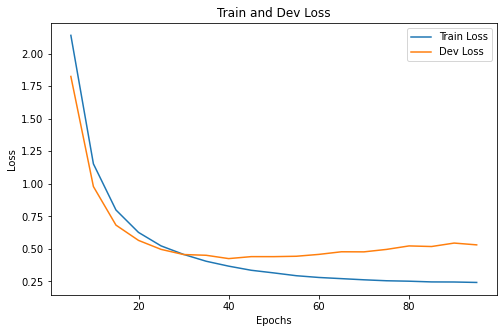

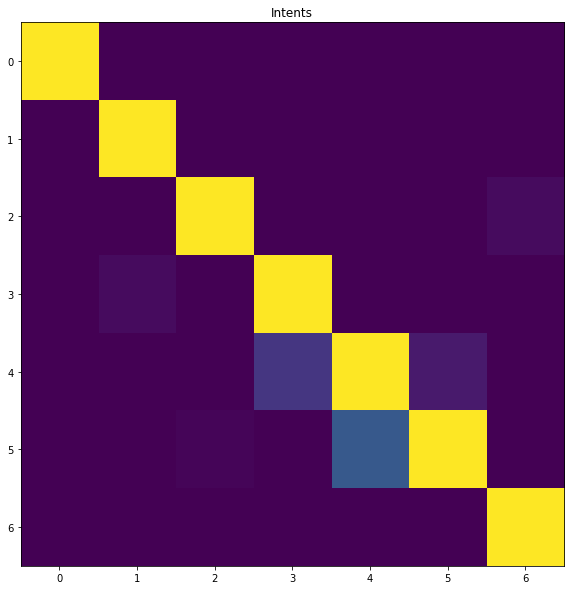

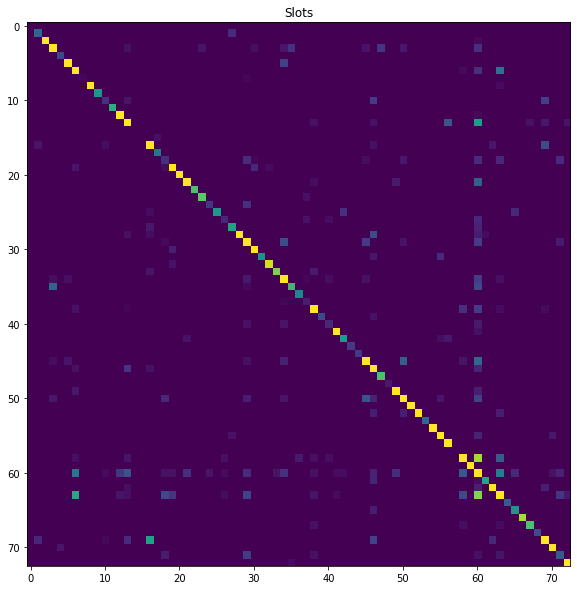

In [ ]:
plot_losses(sampled_epochs, losses_train, losses_dev)

plot_confusion_matrix(cm_int, label="Intents")
plot_confusion_matrix(cm_slot, label="Slots")

In [ ]:
train_5_times(EncoderDecoderModel, train_loader_SNIPS, dev_loader_SNIPS, test_loader_SNIPS, lang_SNIPS)

These results are averaged from the training of the simpler model (EncoderDecoderModel, not EncoderDecoderModelTest), as training for the more complex architecture took over two  hours for 100 epochs

In [ ]:
f1_results = [0.7960064759848893, 0.805697393173878, 0.7678476996298254,  0.7956873315363883, 0.7765089722675367]
acc_results = [0.97, 0.9671428571428572, 0.9657142857142857, 0.9671428571428572, 0.9642857142857143]

f1_mean = sum(f1_results) / len(f1_results)
acc_mean = sum(acc_results) / len(acc_results)

print("F1 Mean: ", f1_mean)
print("F1 Var: ", round(sum([(f - f1_mean)**2 for f in f1_results]), 4))
print("Acc Mean: ", acc_mean)
print("Acc Var: ", round(sum((f - acc_mean)**2 for f in acc_results), 6))